In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools
import umap
from colour import Color
from collections import Counter
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from group_analysis import do_kmeans_clustering, plot_clusters, log_and_scale, colour_list, display_group_kw_combis
from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from clustering import reduce_features, make_elbow_plot, compare_binary_normed_feature_embeddings, mc_list, plot_bin_and_norm_clusters, plot_contingency_matrix, calculate_cluster_lrs

from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix
from language_change_methods.utility_functions import basic_preprocessing, get_ngram_example, get_text_example_of_pos, make_ngram_concordance, make_pos_concordance

from sklearn.cluster import KMeans, SpectralClustering, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk import ngrams as make_ngrams

from settings import TFES_FP as DB_FP, TFES_TOK_FP
GRAPH_DIR = "./Graphs"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos(TFES_TOK_FP)}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]
pos = pos.loc[toks.index]

fe_posts = fe_posts.loc[toks.index]

Wall time: 31 s


In [4]:
with open("../data/user_metagroup.json") as group_file:
    meta_clusts = pd.Series(json.load(group_file))
    meta_clusts.index = meta_clusts.index.astype("float64")

In [5]:
post_lengths = toks.apply(len)
user_n_words = post_lengths.groupby(fe_posts["poster_id"]).sum()
posts_per_user = fe_posts.groupby("poster_id").size()

over_100 = posts_per_user[posts_per_user > 100]
print(f"{len(over_100)} with > 100 posts")

top_20 = posts_per_user.sort_values(ascending=False).head(20)
print(f"{len(top_20)} in the top 20")

curr_users = meta_clusts[meta_clusts == "Core Community"].index
    
user_n_words = user_n_words.loc[curr_users]
posts_per_user = posts_per_user.loc[curr_users]

curr_posts = fe_posts.query("poster_id in @curr_users")

# Get colour gradient
colour_gradient = list(Color("red").range_to(Color("blue"),len(curr_users)))
colour_gradient = pd.Series(colour_gradient, index=posts_per_user.loc[curr_users].sort_values(ascending=True).index)
colour_gradient = colour_gradient.loc[curr_users].apply(str)

101 with > 100 posts
20 in the top 20


# Create the user text chunks

In [6]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

def get_chunks(u, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield u, tokens[i:i+chunk_size]

In [7]:
def make_tok_chonks(tokens, chunk_size):
    user_chunks = [[[user, chunk] for user, chunk in get_chunks(user, curr_toks, chunk_size)] for user, curr_toks in tokens.items()]
    user_chunks = merge_lists(user_chunks)
    user_chunks = pd.DataFrame(user_chunks, columns=["User", "Chunk"])
    return user_chunks

In [8]:
CHUNK_SIZE = 1000

In [9]:
%%time
user_toks = toks.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_chunks = make_tok_chonks(user_toks, CHUNK_SIZE)

Wall time: 676 ms


In [10]:
%%time
user_pos = pos.groupby(curr_posts["poster_id"]).apply(merge_lists)
user_pos_chunks = make_tok_chonks(user_pos, CHUNK_SIZE)

Wall time: 1.05 s


# Create the Different Feature Counts

#### BOW

In [11]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in user_toks.items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 10000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 34.7 s


#### Tfidf bow counts

In [12]:
%%time
# Credit for this cell: http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/
from sklearn.feature_extraction.text import TfidfVectorizer
# If you had counts instead of tokens, you'd use "TfidfTransformer"

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  


tfidf_matrix = tfidf.fit_transform(user_toks)

Wall time: 1.19 s


In [13]:
tfidf_feats = tfidf_matrix[:, np.isin(tfidf.get_feature_names(), top_n)].todense()

#### PoS Trigrams

In [14]:
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in user_pos], index=user_pos.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

In [15]:
top_n = [x[0] for x in Counter(merge_lists(pos_trigrams)).most_common(1000)]
pos_tri_counts = pos_trigrams.apply(Counter).apply(lambda dic: {w: c for w, c in dic.items() if w in top_n})
pos_tri_counts = pd.Series(pos_tri_counts)

In [16]:
# pos_tri_chunks = pd.DataFrame(index=user_pos_chunks.index)
# pos_tri_chunks["User"] = user_pos_chunks["User"]
# pos_tri_chunks["Chunk"] = pos_trigrams

# Create the Feature Matrix

In [17]:
%%time
# Initialise feats to None
bin_feats = None
norm_feats = None

# Make the feature matrix
curr_feat_type = "pos_tri"
SCALE = True
APPLY_PCA = True

if curr_feat_type == "pos_tri":
    curr_counts = pos_tri_counts
    curr_toks = pos_trigrams
elif curr_feat_type == "bow":
    curr_counts = bow_counts
    curr_toks = user_toks
elif curr_feat_type == "tfidf":
    curr_counts = bow_counts
    curr_toks = user_toks
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(tfidf_feats)
    norm_feats = tfidf_feats
    
if bin_feats is None:
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / user_toks.apply(len).values[:,None]

Wall time: 144 ms


#### Scaling

In [18]:
if SCALE:
    norm_feats = StandardScaler().fit_transform(norm_feats)

#### PCA reduction

In [19]:
%%time
from sklearn.decomposition import PCA
pca = PCA(.95)

if APPLY_PCA:
    norm_feats = pca.fit_transform(norm_feats)

Wall time: 113 ms


In [20]:
print(f"{norm_feats.shape[1]} components")

158 components


#### Make 2d embeddings

In [21]:
%%time
norm_embedding = reduce_features(norm_feats)

Wall time: 5.46 s


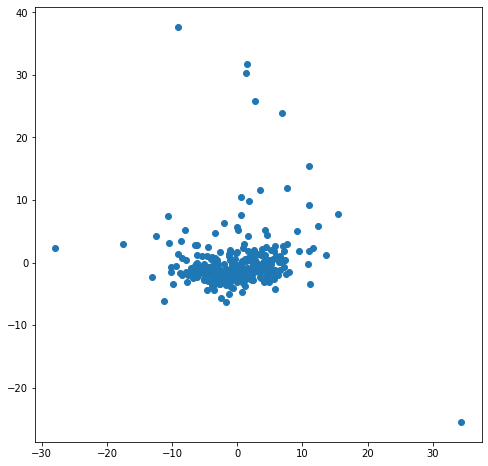

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(norm_feats[:,0], norm_feats[:,1])
plt.show()

# Do the Clustering

In [23]:
from sklearn.cluster import KMeans

In [57]:
model = KMeans(n_clusters=2, random_state=123)
clusters1 = model.fit_predict(norm_feats)

avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters1)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Normed:	 0.004148975872482042 



In [58]:
model = KMeans(n_clusters=20, random_state=123)
clusters2 = model.fit_predict(norm_feats)

avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters2)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Normed:	 -0.030772577497767593 



In [59]:
model = KMeans(n_clusters=3, random_state=123)
clusters3 = model.fit_predict(norm_feats)

avg_silhouette_score = metrics.silhouette_score(norm_feats, clusters3)
print("Average silhoette score for Normed:\t", avg_silhouette_score, "\n")

Average silhoette score for Normed:	 0.42713498466802263 



In [53]:
for i in range(2,20):
    model = KMeans(n_clusters=i, random_state=123)
    curr_clusts = model.fit_predict(norm_feats)
    avg_silhouette_score = metrics.silhouette_score(norm_feats, curr_clusts)
    print(f"Average silhoette score for {i}:\t", avg_silhouette_score)

Average silhoette score for 2:	 0.004148975872482042
Average silhoette score for 3:	 0.42713498466802263
Average silhoette score for 4:	 0.028068192859392938
Average silhoette score for 5:	 0.03265235039200874
Average silhoette score for 6:	 0.03503802427913502
Average silhoette score for 7:	 0.03455381628937912
Average silhoette score for 8:	 0.010281907014664658
Average silhoette score for 9:	 0.011058187792701828
Average silhoette score for 10:	 0.013143056274145597
Average silhoette score for 11:	 0.013365476820103266
Average silhoette score for 12:	 0.013941422353970478
Average silhoette score for 13:	 0.015997040312004468
Average silhoette score for 14:	 -0.026567077966848655
Average silhoette score for 15:	 -0.031007974489222333
Average silhoette score for 16:	 0.017141666439754306
Average silhoette score for 17:	 -0.03702248329469701
Average silhoette score for 18:	 -0.03627724066238763
Average silhoette score for 19:	 -0.033425814903719854


In [85]:
%%time
sum_squared_dists = []
K = range(1,20, 1)
for k in K:
    km = KMeans(n_clusters=k, random_state=123)
    km = km.fit(norm_feats)
    sum_squared_dists.append(km.inertia_)

Wall time: 1.3 s


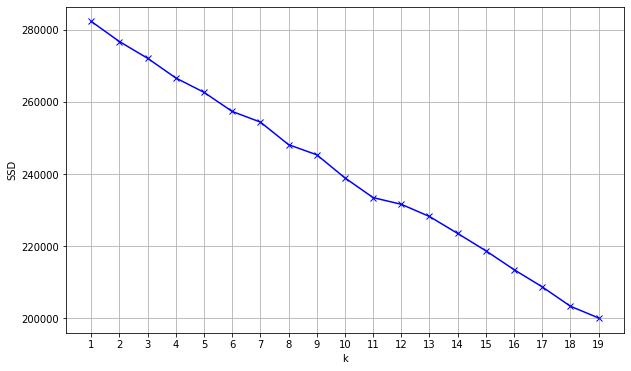

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K, sum_squared_dists, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('SSD')
ax.set_xticks(K)
ax.grid()
plt.show()

In [96]:
clusters = clusters1

In [97]:
for clust in set(clusters):
    print(f"Num users in Cluster {clust}: {len(user_toks[clusters==clust].index)}")

Num users in Cluster 0: 193
Num users in Cluster 1: 104


In [83]:
for clust in set(clusters):
    print(f"Num words in Cluster {clust}: {len(merge_lists(user_toks[clusters==clust]))}")

Num words in Cluster 0: 2937019
Num words in Cluster 1: 3054819


In [84]:
for clust in set(clusters):
    print(f"Avg words in Cluster {clust}: {user_toks[clusters==clust].apply(len).mean():.0f}")
    print(f"Median words in Cluster {clust}: {user_toks[clusters==clust].apply(len).median():.0f}")
    print()

Avg words in Cluster 0: 15218
Median words in Cluster 0: 4579

Avg words in Cluster 1: 29373
Median words in Cluster 1: 5252



In [64]:
print(",".join(map(str, user_toks[user_toks.index.isin(top_20.index)].index)))
print(",".join(map(str, clusters[user_toks.index.isin(top_20.index)])))

2.0,16.0,32.0,38.0,62.0,99.0,315.0,376.0,464.0,706.0,709.0,775.0,843.0,1206.0,1342.0,1423.0,1448.0,1500.0,1584.0,1804.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
for i, (c1, c2) in enumerate(zip(clusters[user_toks.index.isin(top_20.index)], clusters2[user_toks.index.isin(top_20.index)])):
    print(i, c1, c2, sep=",")

0,0,1
1,0,12
2,0,1
3,1,12
4,0,12
5,1,6
6,1,6
7,1,12
8,0,1
9,1,12
10,0,12
11,0,1
12,0,1
13,0,3
14,1,12
15,1,12
16,1,12
17,1,12
18,1,12
19,0,1


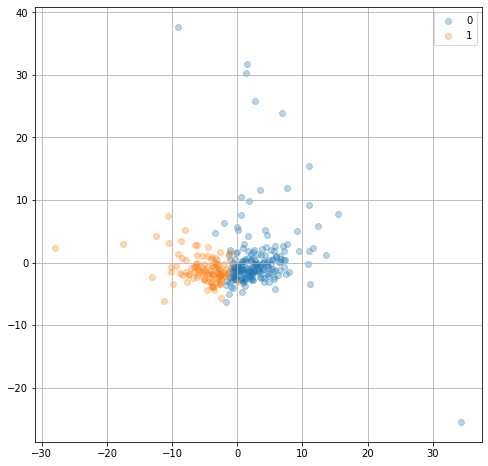

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
for c in set(clusters):
    ax.scatter(norm_feats[clusters==c,0], norm_feats[clusters==c,1], label=c, alpha=0.3)
ax.grid()
ax.legend()
plt.show()

# Analyse Spread Across Users

In [32]:
user_toks.index[clusters==0]

Float64Index([   1.0,    2.0,    3.0,    4.0,    5.0,    7.0,    9.0,   11.0,
                14.0,   15.0,
              ...
              2015.0, 2056.0, 2105.0, 2144.0, 2149.0, 2163.0, 2184.0, 2207.0,
              2218.0, 2243.0],
             dtype='float64', name='poster_id', length=193)

In [33]:
user_toks.index[clusters==1]

Float64Index([  18.0,   35.0,   38.0,   44.0,   48.0,   59.0,   64.0,   65.0,
                75.0,   85.0,
              ...
              2089.0, 2114.0, 2166.0, 2167.0, 2195.0, 2222.0, 2223.0, 2236.0,
              2259.0, 2282.0],
             dtype='float64', name='poster_id', length=104)

In [34]:
contingency = pd.crosstab(user_toks.index.values, [clusters], rownames=["User"], colnames=["Cluster"])

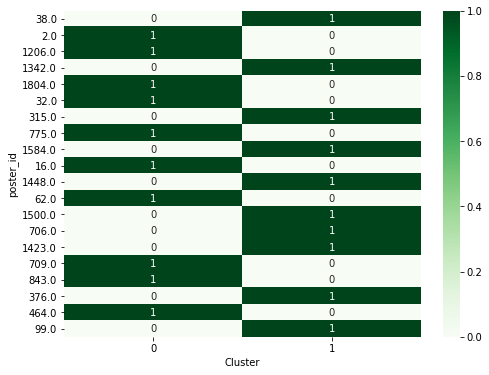

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(contingency.loc[top_20.index], annot=True, ax=ax, fmt='g', cmap="Greens")
# fig.savefig(os.path.join(GRAPH_DIR, f"chunk_contingency_2_{curr_feat_type}.pdf"))
plt.show()

# Get Some Keywords Between Clusters

In [36]:
%%time
lr = lambda x, y: np.log2(x / y)

def get_cluster_keywords(tokens, clusters):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > 100}
        lrs = pd.Series(lrs).sort_values(ascending=False)
        t10_lr = lrs.head(20)
        b10_lr = lrs.tail(20)

        print(clust)
        print("-------------------------------------------------------------------------------------")
        for (w1, lr1), (w2, lr2) in zip(t10_lr.items(), b10_lr.items()):
            print(f"{w1:20}\t{lr1:10.2f}\t|\t{w2:20}\t{lr2:10.2f}")
        print("-------------------------------------------------------------------------------------")

Wall time: 0 ns


In [37]:
def get_cluster_lrs(tokens, clusters, min_freq=100):
    
    clust_counts = tokens.groupby(clusters).apply(
                    lambda x: [Counter(merge_lists(x))]).apply(
                    lambda x: x[0])
    clust_n_words = {clust: tokens[clusters==clust].apply(len).sum() for clust in set(clusters)}
    
    clust_kw = dict()

    for clust, counts in clust_counts.items():
        other_counts = Counter(merge_lists(tokens[clusters!=clust]))
        other_nwords = tokens[clusters!=clust].apply(len).sum()
        lrs = calculate_cluster_lrs(counts, other_counts, clust_n_words[clust], other_nwords)
        lrs = {w: l for w, l in lrs.items() if counts[w] > min_freq}
        lrs = pd.Series(lrs).sort_values(ascending=False)
   
        clust_kw[clust] = lrs
    return clust_kw

In [38]:
%%time
get_cluster_keywords(pos_trigrams, clusters)

0
-------------------------------------------------------------------------------------
ADV_INTJ_PUNCT      	      1.63	|	PUNCT_NUM_PUNCT     	     -1.69
NUM_DET_PUNCT       	      1.48	|	PROPN_PUNCT_PROPN   	     -1.69
PRON_PART_ADV       	      1.41	|	ADP_PROPN_NUM       	     -1.69
INTJ_VERB_SCONJ     	      1.38	|	NUM_PUNCT_PUNCT     	     -1.70
PRON_ADV_PART       	      1.37	|	PUNCT_PROPN_ADP     	     -1.71
PUNCT_INTJ_INTJ     	      1.36	|	NOUN_PROPN_PROPN    	     -1.76
INTJ_INTJ_PUNCT     	      1.31	|	SYM_NUM_SYM         	     -1.80
INTJ_PUNCT_AUX      	      1.29	|	PROPN_PROPN_NUM     	     -1.82
VERB_ADJ_PRON       	      1.29	|	NUM_ADP_NUM         	     -1.82
INTJ_PUNCT_ADJ      	      1.28	|	PROPN_PROPN_ADP     	     -1.86
PART_ADV_NOUN       	      1.25	|	PROPN_ADP_PROPN     	     -1.89
PRON_ADJ_ADV        	      1.25	|	PROPN_ADV_DET       	     -1.92
PART_ADJ_PRON       	      1.18	|	PUNCT_NUM_PROPN     	     -1.95
PRON_ADV_SCONJ      	      1.16	|	NUM_PUNCT_NUM       

In [39]:
get_text_example_of_pos(["PUNCT", "INTJ", "INTJ"], 
                        user_pos[clusters==0], 
                        user_toks[clusters==0], 
                        doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 326:
2.0        ouncilors have voting privileges now . uh oh , fixed . gah. fixed . well , that w
2.0         i . live up to your own standards . hell yeah . or we could use lulu , like tint
2.0        possible is considerably harder than " oh no , it takes effort " all us dollars a
2.0        ave breasts . my chest is very flat . hi fogo4 , thanks for stopping by . this cla
2.0        inal claim from the very same page ) : oh my . you did n't think it magically tra
2.0        , and then you 'd probably say that " oh well , they were pretty close to speakin
2.0        warning to this effect will follow . hi hoopera , thanks for stopping by . i hope 
2.0        ermines what i said or did n't say ? gosh darn it , why was n't i informed !? i a
2.0        now , falsity implies all statements . oh my . perhaps you should n't have used t
2.0         piece of very anecdotal evidence . hi sandokhan , i will repeat this to you once 
2.0         tried denying that your position

In [40]:
%%time
concs = make_pos_concordance(["NUM", "PROPN", "NUM"],
                             user_pos[clusters==1],
                             user_toks[clusters==1],
                             doc_labels=user_toks[clusters==1].index)
concs = pd.DataFrame(concs, columns=["user", "conc"])

print("Distribution across users:")
num_uses_per_user = concs.groupby("user").size()
print("Num uses per user", num_uses_per_user, sep="\n", end="\n\n")
print("Mean uses per user:\t", num_uses_per_user.mean())
print("Median uses per user:\t", num_uses_per_user.median())

Distribution across users:
Num uses per user
user
18.0       3
38.0      11
59.0      17
65.0       1
85.0      28
99.0       3
103.0      2
155.0      4
236.0      1
315.0     71
376.0      1
603.0      2
704.0      1
844.0      1
864.0      3
1342.0    20
1448.0     4
1459.0     2
1500.0     8
1584.0    11
2166.0     1
2222.0     3
dtype: int64

Mean uses per user:	 9.0
Median uses per user:	 3.0
Wall time: 2.36 s


In [41]:
%%time
get_cluster_keywords(user_toks, clusters)

0
-------------------------------------------------------------------------------------
fora                	      4.61	|	device              	     -1.47
roger               	      4.32	|	toward              	     -1.47
ic                  	      4.06	|	route               	     -1.51
refrain             	      4.02	|	coordinate          	     -1.52
gon                 	      3.71	|	west                	     -1.55
warned              	      3.68	|	measurement         	     -1.56
loved               	      3.38	|	equator             	     -1.59
warning             	      3.12	|	refraction          	     -1.62
na                  	      2.86	|	12                  	     -1.64
shit                	      2.81	|	enag                	     -1.66
dude                	      2.79	|	formula             	     -1.67
strawman            	      2.77	|	â                	     -1.72
reers               	      2.75	|	coriolis            	     -1.79
lol                 	      2.75	|	range               

In [42]:
%%time
clust_lrs = get_cluster_lrs(user_toks, clusters)

Wall time: 2.01 s


In [43]:
(clust_lrs[0]["re'ers"])

1.4006887044846188

In [44]:
clust_lrs[1]["fe'ers"]

0.6630488414550166

In [45]:
clust_lrs[1]["flat"]

0.126982165669484

In [46]:
clust_lrs[1]["round"]

-0.11538642897963299

In [47]:
c1 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["flat", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 549 / 2937019
Cluster 1: 397 / 3054819


0.5238989240447709

In [48]:
c1 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["round", "earthers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 196 / 2937019
Cluster 1: 73 / 3054819


1.4754474606894996

In [51]:
c1 = len(make_ngram_concordance(["fe'ers"],
                                user_toks[clusters==0],
                                doc_labels=user_toks[clusters==0].index))

c2 = len(make_ngram_concordance(["fe'ers"],
                                user_toks[clusters==1],
                                doc_labels=user_toks[clusters==1].index))

n1 = user_toks[clusters==0].apply(len).sum()
n2 = user_toks[clusters==1].apply(len).sum()

print(f"Cluster 0: {c1} / {n1}")
print(f"Cluster 1: {c2} / {n2}")
lr((c1+0.5)/n1, (c2+0.5)/n2)

Cluster 0: 236 / 2937019
Cluster 1: 389 / 3054819


-0.6630488414550164

In [49]:
get_ngram_example(["fe'ers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 236:
2.0        ts in which " theory " may be used by fe'ers . within the context of " conspiracy 
2.0        s used in exactly the same fashion by fe'ers as other scientists , by way of provi
2.0        y be correct if he simply spoke to no fe'ers at all . personally , i propose that 
2.0        t large . that is not a claim serious fe'ers would make , in my humble opinion . p
2.0        ct and following the more influential fe'ers online . in other words : yes , but y
2.0        hat the most - supported map is among fe'ers . could you just go away now ? how do
2.0        uld be silly . rowbotham 's and other fe'ers ' experiments are reproducible . rabi
2.0        ised for some of the more belligerent fe'ers which appeared to target him at the t
2.0        ace in the few . yes , there are some fe'ers who are working on alternative models
2.0        olly , we sure showed those gosh darn fe'ers ! " engaging with them is an utter wa
2.0        gestions have garnered cri

In [50]:
get_ngram_example(["flat", "earthers"],
                  user_toks[clusters==0],
                  doc_labels=user_toks[clusters==0].index, n_examples=25)

Showing 25 out of 549:
2.0        er well . unfortunately , not all flat earthers are zeteticists , and we do have 
2.0         comments from round earthers and flat earthers alike , i would like to ask every
2.0         answering questions on behalf of flat earthers , especially if you 're going to 
2.0        . a bunch of the things you say " flat earthers " claim simply do not apply to th
2.0        ng something along the lines of " flat earthers claim that 2+2=5 and that is wron
2.0        ere , welcome to the forum . most flat earthers are primarily concerned with the 
2.0        nestly do n't think there are any flat earthers here who would claim california a
2.0        up a relatively small minority of flat earthers , very far from your alleged " al
2.0        way to carry on doing his thing . flat earthers ( or fe'ers for short ) is the mo
2.0        adbible ( click ) 21/08/2017 what flat earthers are saying about the total solar 
2.0         global news ( click ) 30/10/2017 fl